#GWP 2

## Part 1

In this part we are going to work wiht 7 assets {AAPL, NVDA, TSLA, XOM, REGN, LLY, JPM}. and we are going to build 3 optimal portfolio with different constraints:

*   With no short selling
*   No short selling with 20% cap on each asset
*   Short selling allowed

we will use yahoo finance to gather daily data for the assets and cvxpy package for optimization.
In optimization our goal will be to balance risk and return with a specific risk-aversion parameter $(λ)$ i.e. 0.5.





In [58]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis
import cvxpy as cp

In [59]:
# Data gathering
tickers = ["AAPL","NVDA","TSLA","XOM","REGN","LLY","JPM"]
start_date = "2022-01-01"
end_date = "2024-12-31"

df = yf.download(tickers, start=start_date, end=end_date,auto_adjust=False)["Adj Close"]

[*********************100%***********************]  7 of 7 completed


In [60]:
df.head()

Ticker,AAPL,JPM,LLY,NVDA,REGN,TSLA,XOM
Date,,,,,,,
2022-01-03,178.879913,147.901230,263.726715,30.070988,627.099976,399.926666,56.641762
2022-01-04,176.609634,153.508118,258.951599,29.241369,616.820007,383.196655,58.772293
2022-01-05,171.911865,150.701691,252.973053,27.558168,595.119995,362.706665,59.503265
2022-01-06,169.042068,152.302734,251.691910,28.131210,598.440002,354.899994,60.902821
2022-01-07,169.209137,153.811783,251.856918,27.201761,603.729980,342.320007,61.402020


<Axes: xlabel='Date'>

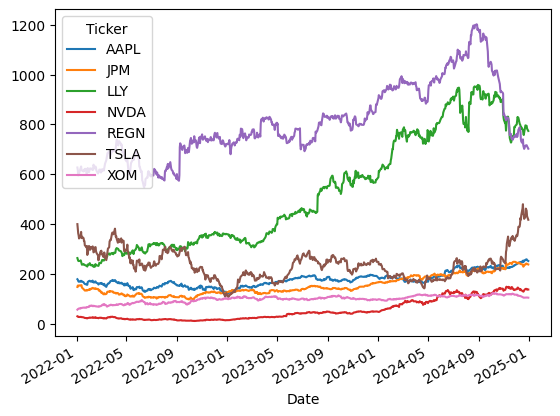

In [61]:
# plot for all assets
df.plot()

In [62]:
returns = df.pct_change().dropna()

In [63]:
# Summary statistics
summary = pd.DataFrame({
    'Mean': returns.mean() * 252,
    'Volatility': returns.std() * np.sqrt(252),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})
summary

,Mean,Volatility,Skewness,Kurtosis
Ticker,,,,
AAPL,0.151531,0.271079,0.211647,2.509906
JPM,0.190914,0.250079,0.398017,5.729736
LLY,0.402398,0.288038,0.982351,7.203078
NVDA,0.660925,0.552875,0.682174,4.010806
REGN,0.074200,0.270463,1.398593,22.488295
TSLA,0.201383,0.613143,0.243420,2.194842
XOM,0.243678,0.272275,-0.119053,1.453567


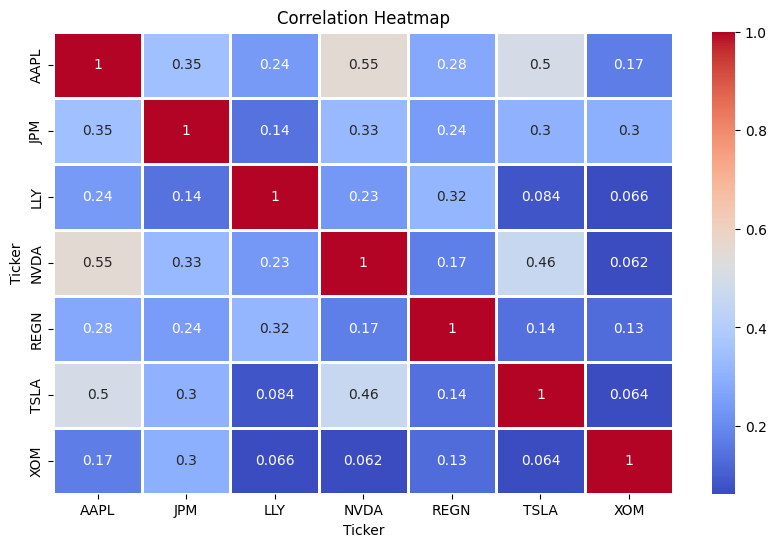

In [64]:
# assets correlation heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', ax=ax,linewidths=1)
ax.set_title('Correlation Heatmap')
plt.show()


In [65]:
# some necessary data points for optimization
cov_matrix = returns.cov()*252
exp_returns = returns.mean()*252
m = exp_returns.shape[0]
Q = np.array(cov_matrix)
r = np.array(exp_returns)

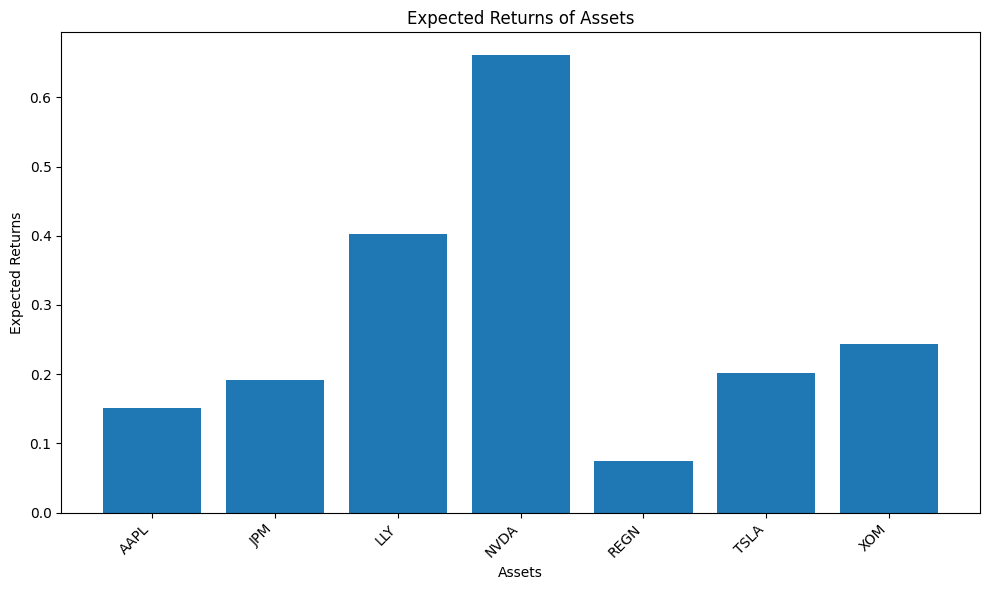

In [66]:
# Expcted returns of assets

plt.figure(figsize=(10, 6))
plt.bar(exp_returns.index, exp_returns.values)
plt.xlabel("Assets")
plt.ylabel("Expected Returns")
plt.title("Expected Returns of Assets")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

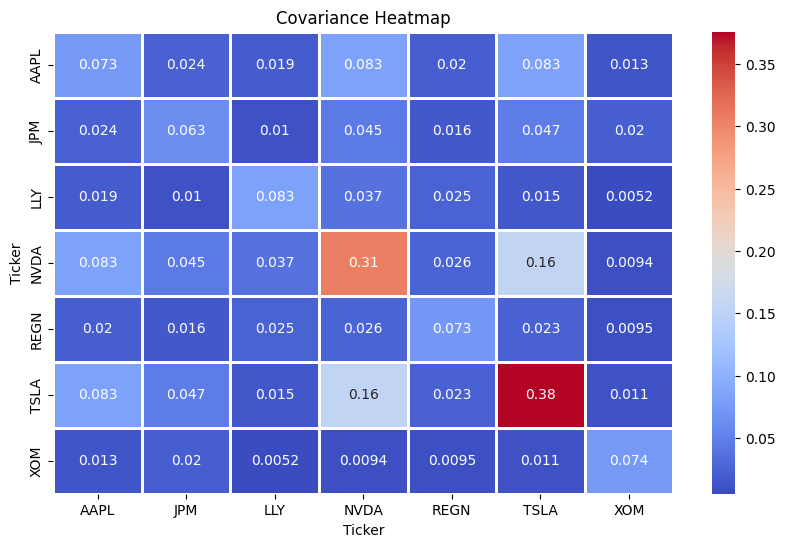

In [67]:
# variance-covaraince heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', ax=ax,linewidths=1)
ax.set_title('Covariance Heatmap')
plt.show()

In [68]:
# MVO function

x = cp.Variable(m)

def opt_port(cov_matrix, constraints):
  risk = cp.quad_form(x, Q)
  objective = cp.Maximize((-1/2)*risk + r.T @ x)
  prob = cp.Problem(objective, constraints)
  prob.solve()
  return x.value.round(4)

In [69]:
# Portolio 1: No shorting
constraints_step1 = [cp.sum(x) == 1, x >= 0]
weights_step1 = opt_port(cov_matrix, constraints_step1)

# Portolio 2: No shorting + 20% cap
constraints_step2 = [cp.sum(x) == 1, x >= 0, x <= 0.2]
weights_step2 = opt_port(cov_matrix, constraints_step2)

# Portolio 3: Shorting allowed
constraints_step3 = [cp.sum(x) == 1]
weights_step3 = opt_port(cov_matrix, constraints_step3)

# Weights table
results = pd.DataFrame({
    'Asset': tickers,
    'Step 1': weights_step1,
    'Step 2': weights_step2,
    'Step 3': weights_step3
}).set_index('Asset')
print(results)

       Step 1  Step 2  Step 3
Asset                        
AAPL   0.0000  0.0939 -2.8957
NVDA   0.0000  0.2000 -0.4408
TSLA   0.0319  0.2000  3.1467
XOM    0.9681  0.2000  2.3461
REGN   0.0000 -0.0000 -2.4048
LLY    0.0000  0.1061 -0.2035
JPM    0.0000  0.2000  1.4520


In [70]:
#Performance calculation

weights = [weights_step1, weights_step2, weights_step3]
returns = []
volatility = []
sharpe_ratios = []

# Risk-free rate adjustment (annual 4.53% -> U.S 10 Year Treasury Note)
annual_rf = 0.0453
daily_rf = (1 + annual_rf)**(1/252) - 1  # Converting to daily compounded rate

for w in weights:
  opt_ptfolio_ret = np.dot(w, exp_returns)
  opt_ptfolio_stdev = np.sqrt(np.dot(w, Q.dot(w.T)))
  sharpe_ratio = (opt_ptfolio_ret - daily_rf)/ opt_ptfolio_stdev
  returns.append(opt_ptfolio_ret)
  volatility.append(opt_ptfolio_stdev)
  sharpe_ratios.append(sharpe_ratio)



In [71]:
#performance table

step = ['step1', 'step2', 'step3']

performace = pd.DataFrame({
    'Steps': step,
    'Return': returns,
    'Volatility': volatility,
    'Sharpe Ratio': sharpe_ratios
}).set_index('Steps')
print(performace)


         Return  Volatility  Sharpe Ratio
Steps                                    
step1  0.652678    0.537454      1.214063
step2  0.335179    0.229371      1.460529
step3  2.428281    1.503393      1.615084


In [72]:
# Detailed Performance metrics
for i, (ret, vol, sr) in enumerate(zip(returns, volatility, sharpe_ratios)):
    print(f"Step {i+1} Performance:")
    print(f"Expected Return: {ret:.2%}")
    print(f"Volatility: {vol:.2%}")
    print(f"Sharpe Ratio: {sr:.2f}")
    print()

Step 1 Performance:
Expected Return: 65.27%
Volatility: 53.75%
Sharpe Ratio: 1.21

Step 2 Performance:
Expected Return: 33.52%
Volatility: 22.94%
Sharpe Ratio: 1.46

Step 3 Performance:
Expected Return: 242.83%
Volatility: 150.34%
Sharpe Ratio: 1.62



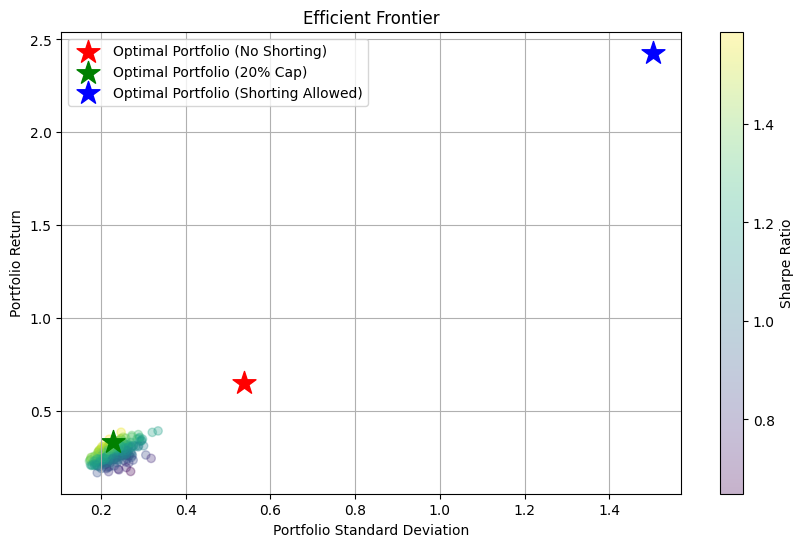

In [73]:
# Plot for optimal portfolio with different contraints and their comparision
# Generating random portfolios
num_portfolios = 250
np.random.seed(42)
weights_matrix = np.random.rand(num_portfolios, len(exp_returns))
weights_matrix = weights_matrix / np.sum(weights_matrix, axis=1, keepdims=True)  # Normalize weights

# portfolio returns and standard deviations
portfolio_returns = np.dot(weights_matrix, exp_returns)
portfolio_std_devs = np.sqrt(np.diag(weights_matrix @ cov_matrix @ weights_matrix.T))

# optimal portfolio metrics for each constraint
def calculate_portfolio_metrics(weights, exp_returns, cov_matrix):
    ret = np.dot(weights, exp_returns)
    std = np.sqrt(np.dot(weights, cov_matrix @ weights.T))
    return ret, std

# Optimal portfolios for each constraint
opt_ret1, opt_std1 = calculate_portfolio_metrics(weights_step1, exp_returns, cov_matrix)  # No shorting
opt_ret2, opt_std2 = calculate_portfolio_metrics(weights_step2, exp_returns, cov_matrix)  # 20% cap
opt_ret3, opt_std3 = calculate_portfolio_metrics(weights_step3, exp_returns, cov_matrix)  # Shorting allowed

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_std_devs, portfolio_returns, c=portfolio_returns / portfolio_std_devs, marker='o', alpha=0.3)
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')

plt.scatter(opt_std1, opt_ret1, color='red', marker='*', s=300, label='Optimal Portfolio (No Shorting)')
plt.scatter(opt_std2, opt_ret2, color='green', marker='*', s=300, label='Optimal Portfolio (20% Cap)')
plt.scatter(opt_std3, opt_ret3, color='blue', marker='*', s=300, label='Optimal Portfolio (Shorting Allowed)')

plt.legend()
plt.grid(True)
plt.show()

## Part 2

Required libraries for part 2

In [74]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import cvxpy as cp
from tqdm import tqdm
import seaborn as sns


Defining number of assets we use for our simulations and also defining the starting and end date to extract the data for assets using yfinance.

In [75]:
num_assets = 20
start_date = "2022-01-01"
end_date = "2024-12-31"

Fectching the data using the yfiance

In [76]:
# Fetch Data
assets = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM", "MSFT", "GOOG", "AMZN", "META", "V", "NFLX", "UNH", "PG", "DIS", "BABA", "KO", "PEP", "NKE"]
data = yf.download(assets, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  20 of 20 completed


### EDA

<Axes: xlabel='Date'>

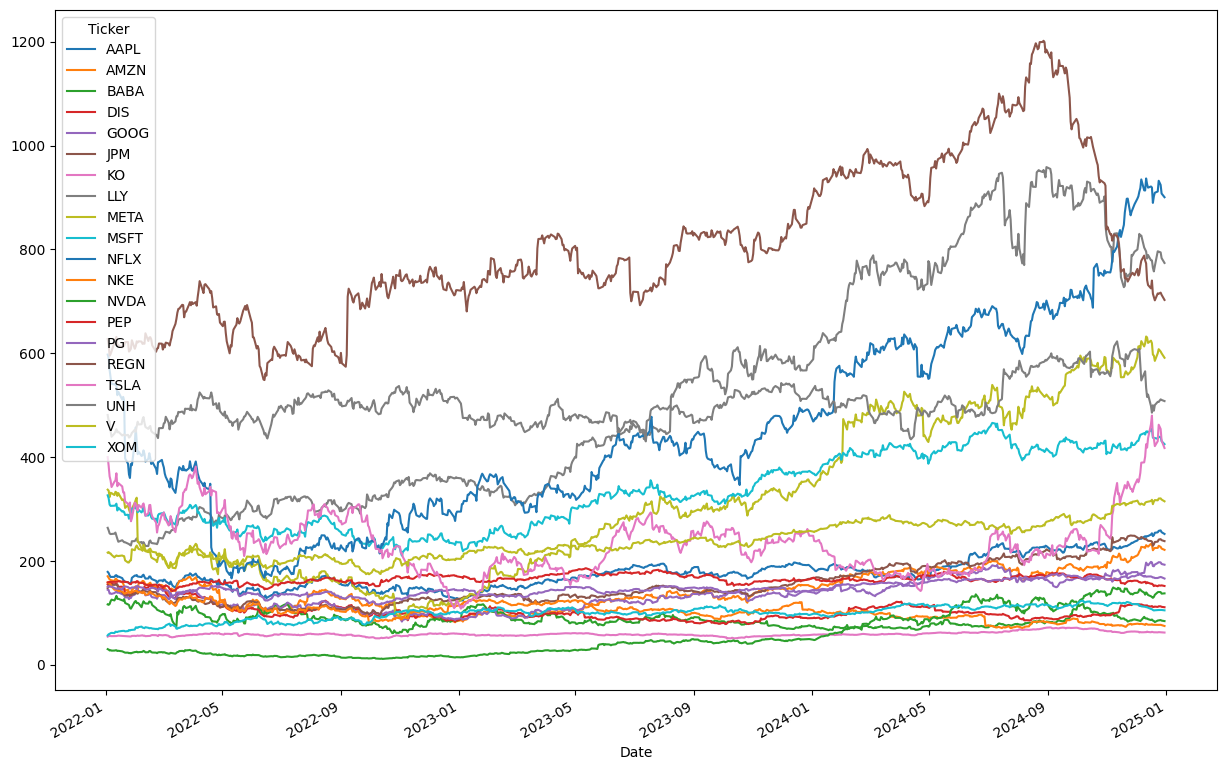

In [77]:
data.plot(figsize=(15,10))

Converting the daily close for each asset to daily retuns

In [78]:
returns = data.pct_change().dropna()  # Use percentage changes

Statistical Summary for each asset individually

In [79]:
# Summary statistics
summary = pd.DataFrame({
    'Mean': np.round(returns.mean() * 252,4),
    'Volatility': np.round(returns.std() * np.sqrt(252),4),
    'Skewness': np.round(returns.skew(),4),
    'Kurtosis': np.round(returns.kurtosis(),4)
})


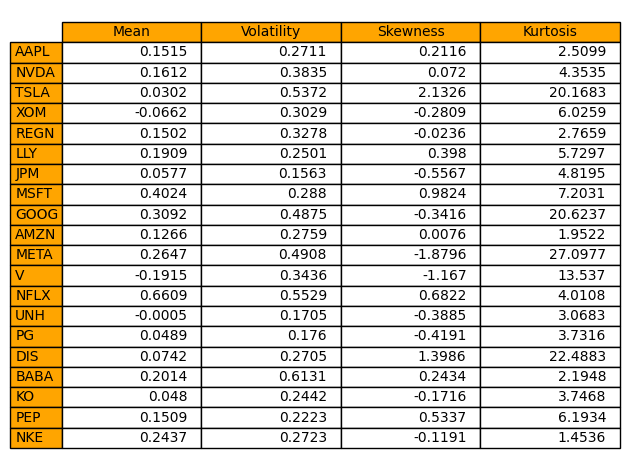

In [80]:
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame(summary, columns=summary.columns)

ax.table(rowLabels=assets,cellText=df.values, colLabels=df.columns, loc='center',colColours=["orange"] * 4,rowColours=["orange"] * 20)

fig.tight_layout()

plt.show()

Plotting the Correation matrix for our asset list

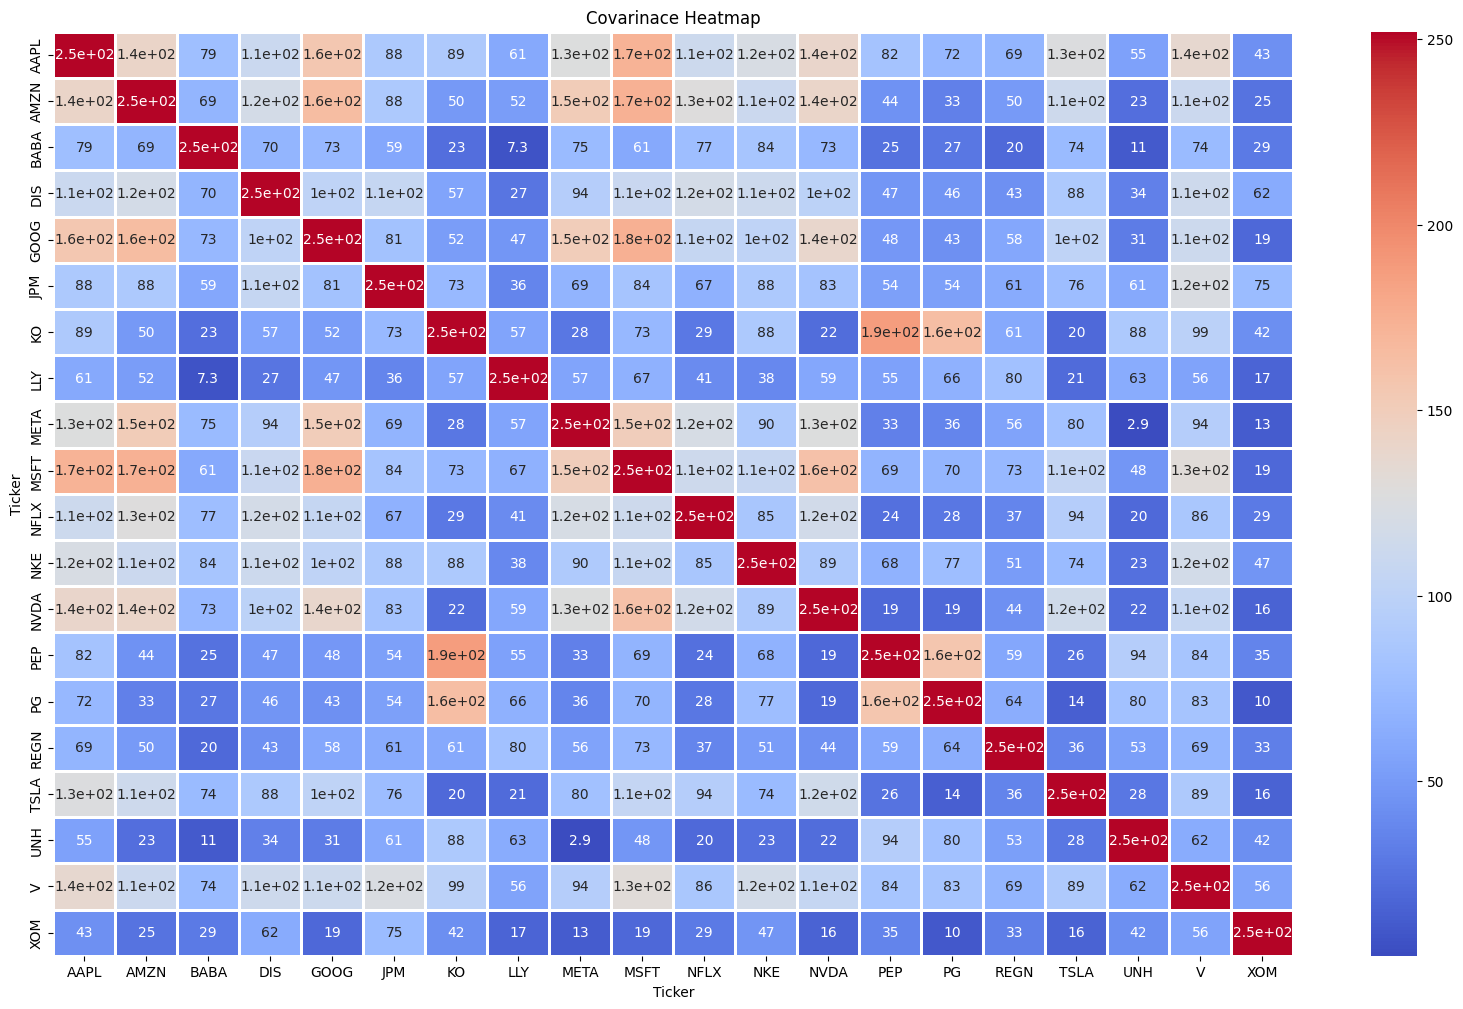

In [81]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(returns.corr()*252, annot=True, cmap='coolwarm', ax=ax,linewidths=1)
ax.set_title('Covarinace Heatmap')
plt.show()

### Monte Carlo Simulations

Defining the parameters-


*   num_simulations : 5000 (number of simulations)
*   num_selected : 5 (number of assets selected randomly from and list in each iteration)
*   train_period : 2 years (approx. 2*252 days/ rows in dataset), train_period is remaining rows or days in dataset.




In [82]:
# Parameters
num_selected = 5
num_simulations = 5000
train_period = 2 * 252  # Approx. 2 years of daily data
test_period = len(returns) - train_period  # 1 year of daily data

In [83]:
#  Monte Carlo Simulations
def monte_carlo_simulations(returns,assets,num_simulations, num_selected, train_period, test_period):
  mvo_returns, equal_returns = [], []

  for _ in tqdm(range(num_simulations), desc="Simulating Portfolios"):
      selected_assets = np.random.choice(assets, num_selected, replace=False)
      train_data, test_data = returns[selected_assets].iloc[:train_period], returns[selected_assets].iloc[train_period:]

      # Estimate mean and covariance from training data
      mean_returns = train_data.mean()
      cov_matrix = train_data.cov()

      # # MVO Optimization (Max Sharpe Ratio, No Short Selling)
      # def neg_sharpe(weights):
      #     port_return = np.dot(weights, mean_returns)
      #     port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
      #     return -port_return / port_vol

      # constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
      # bounds = tuple((0, 1) for _ in range(num_selected))
      # init_guess = np.ones(num_selected) / num_selected
      # result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)
      # mvo_weights = result.x if result.success else init_guess

      # Quadratic Programming for MVO
      w = cp.Variable(num_selected)
      obj_func = (1/2) * cp.quad_form(w, cov_matrix) - w.T @ mean_returns
      constraints = [cp.sum(w) == 1, w >= 0]  # No short selling
      problem = cp.Problem(cp.Minimize(obj_func), constraints)
      problem.solve()
      mvo_weights = w.value if problem.status == 'optimal' else np.ones(num_selected) / num_selected

      # Compute portfolio returns on test data
      mvo_ret = (test_data @ mvo_weights).sum()
      equal_ret = (test_data @ (np.ones(num_selected) / num_selected)).sum()

      mvo_returns.append(mvo_ret)
      equal_returns.append(equal_ret)
  return mvo_returns, equal_returns

In [84]:
# Visualization
def visualize_results(mvo_returns, equal_returns):
  plt.figure(figsize=(10, 5))
  plt.hist(mvo_returns, bins=50, alpha=0.6, label='MVO Portfolio')
  plt.hist(equal_returns, bins=50, alpha=0.6, label='Equal Weight (1/N)')
  plt.legend()
  plt.title("Return Distributions: MVO vs Equal Weight")
  plt.xlabel("Portfolio Return")
  plt.ylabel("Frequency")
  plt.show()

In [85]:
# plot the pdf for returns
def plot_return_distributions(mvo_returns, equal_returns):
  plt.figure(figsize=(10, 5))
  sns.kdeplot(mvo_returns, label='MVO Portfolio', fill=True, alpha=0.6)
  sns.kdeplot(equal_returns, label='Equal Weight (1/N)', fill=True, alpha=0.6)

  # Overlay Normal Distributions
  x_values = np.linspace(min(mvo_returns + equal_returns), max(mvo_returns + equal_returns), 100)
  plt.plot(x_values, norm.pdf(x_values, np.mean(mvo_returns), np.std(mvo_returns)), label='Normal Dist - MVO', linestyle='dashed')
  plt.plot(x_values, norm.pdf(x_values, np.mean(equal_returns), np.std(equal_returns)), label='Normal Dist - Equal Weight', linestyle='dashed')
  # Annotate statistics
  mvo_mean, equal_mean = np.mean(mvo_returns), np.mean(equal_returns)
  mvo_std, equal_std = np.std(mvo_returns), np.std(equal_returns)
  mvo_sharpe = mvo_mean / mvo_std if mvo_std != 0 else np.nan
  equal_sharpe = equal_mean / equal_std if equal_std != 0 else np.nan
  mvo_max_drawdown = np.min(mvo_returns)
  equal_max_drawdown = np.min(equal_returns)

  plt.text(min(x_values), max(norm.pdf(x_values, np.mean(mvo_returns), np.std(mvo_returns))) * 0.9,
          f"MVO - Mean: {mvo_mean:.4f}\n-Std: {mvo_std:.4f}\n-Sharpe: {mvo_sharpe:.4f}\n-Max DD: {mvo_max_drawdown:.4f}",
          fontsize=10, color='blue')
  plt.text(min(x_values), max(norm.pdf(x_values, np.mean(equal_returns), np.std(equal_returns))) * 0.8,
          f"Equal Weights - Mean: {equal_mean:.4f}\n-Std: {equal_std:.4f}\n-Sharpe: {equal_sharpe:.4f}\n-Max DD: {equal_max_drawdown:.4f}",
         fontsize=10, color='red')
  plt.legend()
  plt.title("Return Distributions: MVO vs Equal Weight (PDF)")
  plt.xlabel("Portfolio Return")
  plt.ylabel("Density")
  plt.show()


In [86]:
def calculate_statistics(mvo_returns, equal_returns):
  # Calculate statistics
  mvo_mean = np.mean(mvo_returns)
  equal_mean = np.mean(equal_returns)
  mvo_std = np.std(mvo_returns)
  equal_std = np.std(equal_returns)
  mvo_sharpe, equal_sharpe = mvo_mean / mvo_std, equal_mean / equal_std

  mvo_max_drawdown = np.min(mvo_returns)
  equal_max_drawdown = np.min(equal_returns)

  print(f"MVO Portfolio - Mean Return: {mvo_mean:.4f}, Std Dev: {mvo_std:.4f}, Sharpe Ratio: {mvo_sharpe:.4f}, Max Drawdown: {mvo_max_drawdown:.4f}")
  print(f"Equal Weight - Mean Return: {equal_mean:.4f}, Std Dev: {equal_std:.4f}, Sharpe Ratio: {equal_sharpe:.4f}, Max Drawdown: {equal_max_drawdown:.4f}")


In [87]:
mvo_returns, equal_returns = monte_carlo_simulations(returns,assets,num_simulations, num_selected, train_period, test_period)

Simulating Portfolios: 100%|██████████| 5000/5000 [01:09<00:00, 71.84it/s]


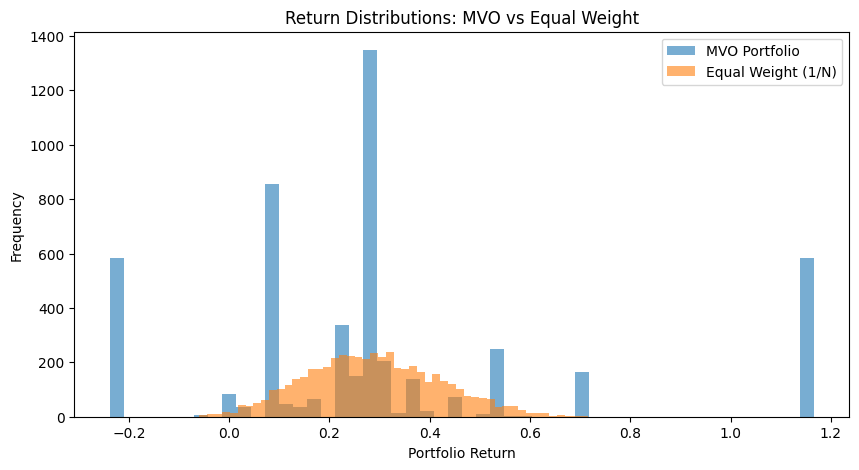

In [88]:
visualize_results(mvo_returns, equal_returns)

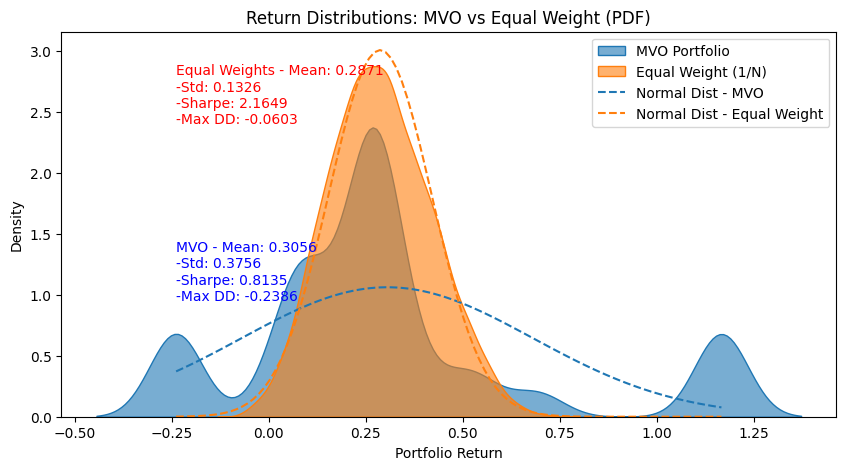

In [89]:
plot_return_distributions(mvo_returns, equal_returns)

In [90]:
calculate_statistics(mvo_returns, equal_returns)

MVO Portfolio - Mean Return: 0.3056, Std Dev: 0.3756, Sharpe Ratio: 0.8135, Max Drawdown: -0.2386
Equal Weight - Mean Return: 0.2871, Std Dev: 0.1326, Sharpe Ratio: 2.1649, Max Drawdown: -0.0603


In [91]:
# Summary statistics
equal_returns = pd.DataFrame(equal_returns)
summary_equal_returns = pd.DataFrame({
    'Mean': np.round(equal_returns.mean() * 252,4),
    'Volatility': np.round(equal_returns.std() * np.sqrt(252),4),
    'Skewness': np.round(equal_returns.skew(),4),
    'Kurtosis': np.round(equal_returns.kurtosis(),4)
})
summary_equal_returns.T

,0
Mean,72.3531
Volatility,2.1055
Skewness,0.1908
Kurtosis,-0.3135


### Extra simulations for differnt type of assets

Assets-


*   equities = AAPL ,NVDA ,TSLA ,XOM ,REGN, LLY, PM, MSFT, GOOG, AMZN
*   bonds = TLT, IEF, SHY, BND, LQD
*   commodities = USO, DBA, UNG
*   metals = GLD, SLV, PPLT


In [92]:
# Define asset categories
equities = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM", "MSFT", "GOOG", "AMZN"]
bonds = ["TLT", "IEF", "SHY", "BND", "LQD"]
commodities = ["USO", "DBA", "UNG"]
metals = ["GLD", "SLV", "PPLT"]

new_assets = equities + bonds + commodities + metals

In [93]:
new_data = yf.download(new_assets, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  21 of 21 completed


In [94]:
new_returns = new_data.pct_change().dropna()  # Use percentage changes

In [95]:
mvo_returns_, equal_returns_ = monte_carlo_simulations(new_returns,new_assets,num_simulations, num_selected, train_period, test_period)

Simulating Portfolios: 100%|██████████| 5000/5000 [01:11<00:00, 69.84it/s]


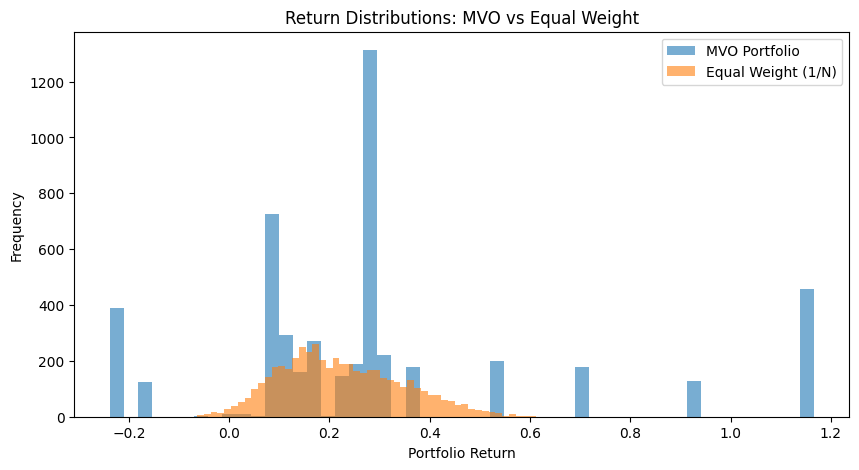

In [96]:
visualize_results(mvo_returns_, equal_returns_)

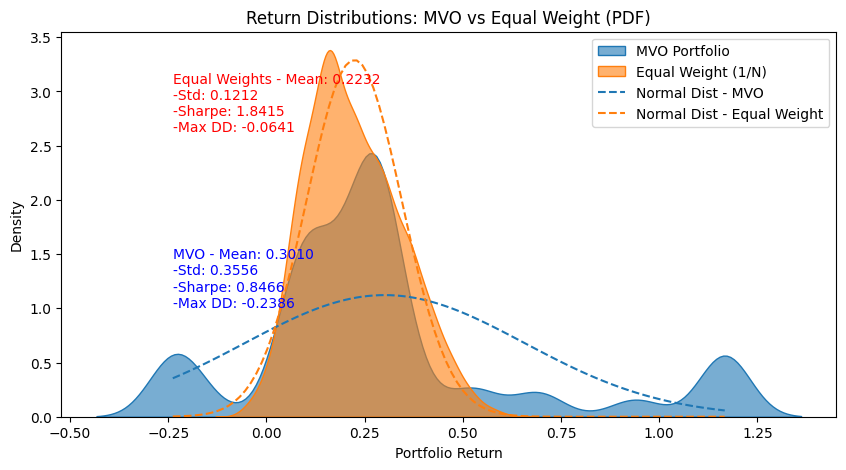

In [97]:
plot_return_distributions(mvo_returns_, equal_returns_)

In [98]:
calculate_statistics(mvo_returns_, equal_returns_)

MVO Portfolio - Mean Return: 0.3010, Std Dev: 0.3556, Sharpe Ratio: 0.8466, Max Drawdown: -0.2386
Equal Weight - Mean Return: 0.2232, Std Dev: 0.1212, Sharpe Ratio: 1.8415, Max Drawdown: -0.0641


## Part 3


### Step 6

In [99]:
import yfinance as yf
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [100]:
assets = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM"]

In [101]:
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2025, 1, 1)
data = yf.download(assets, start=start, end=end)['Close']

[*********************100%***********************]  7 of 7 completed


In [102]:
data.head()

Ticker,AAPL,JPM,LLY,NVDA,REGN,TSLA,XOM
Date,,,,,,,
2022-01-03,178.879913,147.901215,263.726715,30.070984,627.099976,399.926666,56.641766
2022-01-04,176.609619,153.508163,258.951691,29.241365,616.820007,383.196655,58.772289
2022-01-05,171.911850,150.701675,252.973038,27.558167,595.119995,362.706665,59.503265
2022-01-06,169.042068,152.302719,251.691879,28.131214,598.440002,354.899994,60.902824
2022-01-07,169.209122,153.811783,251.856918,27.201759,603.729980,342.320007,61.402012


In [103]:
data.tail()

Ticker,AAPL,JPM,LLY,NVDA,REGN,TSLA,XOM
Date,,,,,,,
2024-12-24,257.916443,241.064987,795.669983,140.220001,714.469971,462.279999,105.456718
2024-12-26,258.735504,241.890717,794.140015,139.929993,716.679993,454.130005,105.545921
2024-12-27,255.309296,239.930847,783.169983,137.009995,712.400024,431.660004,105.536011
2024-12-30,251.923019,238.090363,773.840027,137.490005,702.590027,417.410004,104.822395
2024-12-31,250.144974,238.478348,772.000000,134.289993,712.330017,403.839996,106.616348


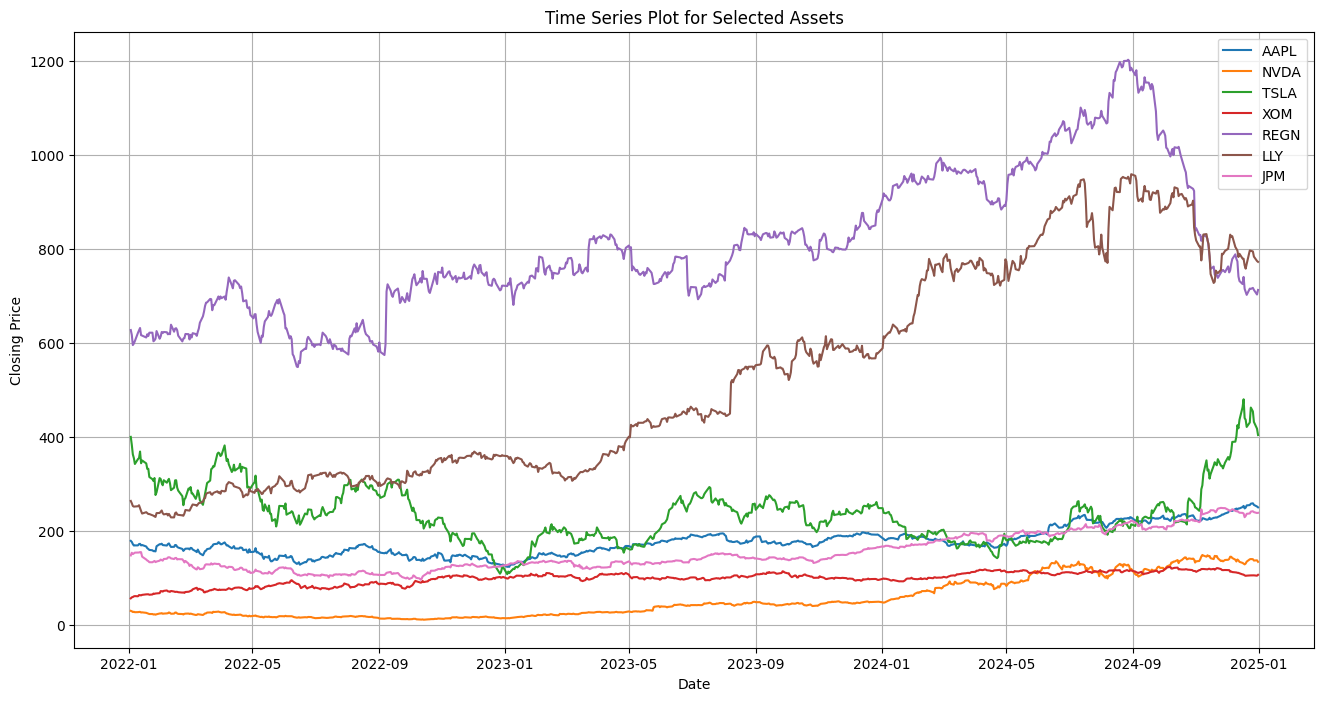

In [104]:

# Plotting time series for assets
plt.figure(figsize=(16, 8))
for asset in assets:
    plt.plot(data.index, data[asset], label=asset)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Time Series Plot for Selected Assets")
plt.legend()
plt.grid(True)
plt.show()


In [105]:
#calculating the geometric returns

df = np.log(data).diff()
df1= df.dropna()

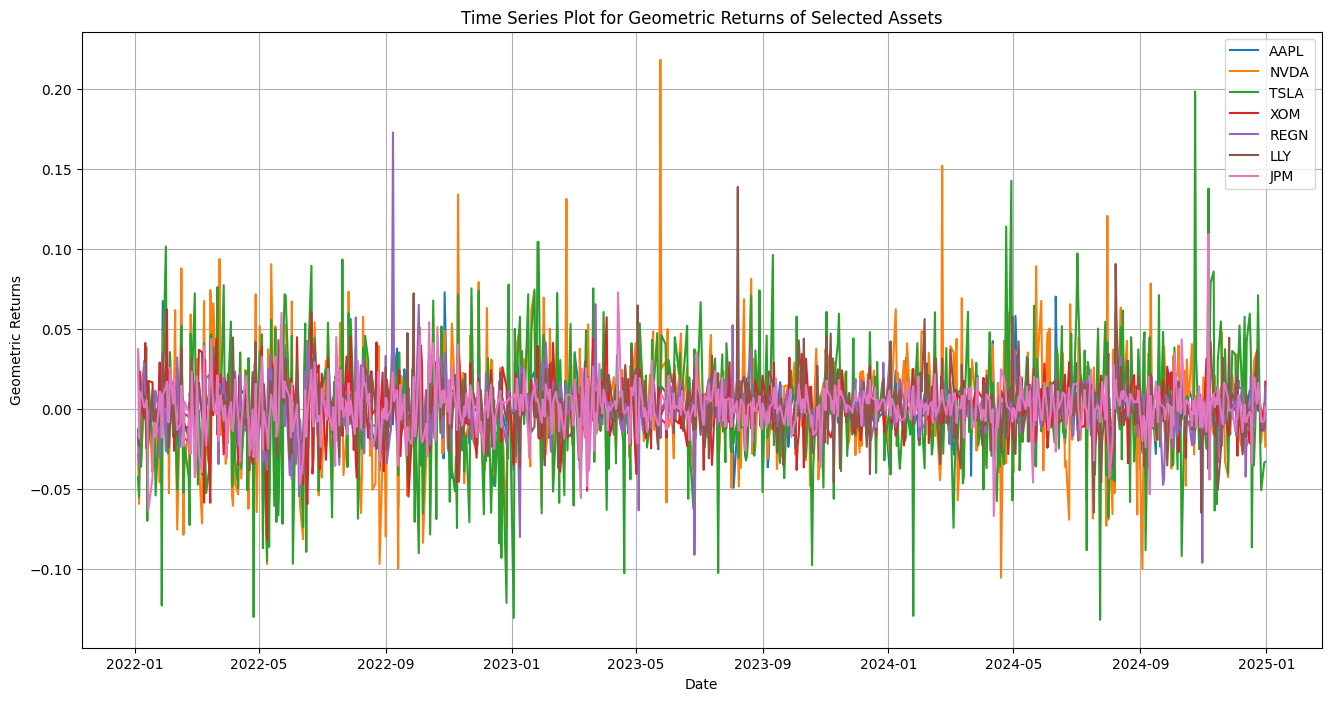

In [106]:
# Plotting time series for df1
plt.figure(figsize=(16, 8))
for asset in assets:
    plt.plot(df1.index, df1[asset], label=asset)
plt.xlabel("Date")
plt.ylabel("Geometric Returns")
plt.title("Time Series Plot for Geometric Returns of Selected Assets")
plt.legend()
plt.grid(True)
plt.show()


In [107]:
def expected_return(dataframe):
  expected_returns = []
  for i in df1.columns:
    expected_returns.append(df[i].mean()*252)
  return np.array(expected_returns)
returns = expected_return(df1)
df_cov = df1.cov()*252
df1_cor = df1.corr()

In [108]:
returns

array([0.11236986, 0.16009169, 0.3599281 , 0.50146689, 0.04270439,
       0.00326312, 0.21195152])

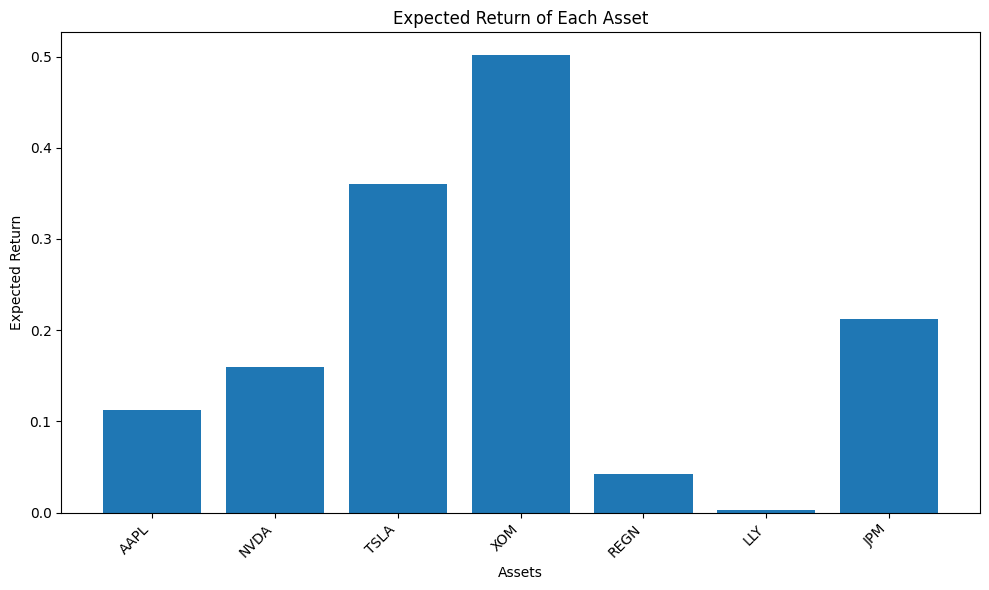

In [109]:
import matplotlib.pyplot as plt

# Plotting expected returns
plt.figure(figsize=(10, 6))
plt.bar(assets, returns)
plt.xlabel("Assets")
plt.ylabel("Expected Return")
plt.title("Expected Return of Each Asset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [110]:
#Mean return of all assets combine

mean_return = np.mean(returns)
print(f"The mean return of all assets combined is: {mean_return}")


The mean return of all assets combined is: 0.19882508137421714


In [111]:

# # AAPL has -5% return
# # NVDA perform 10% better than AAPL
# # TSLA perform 30% better than AAPL
# # XOM has 32% return
# # REGN perform -10% than LLY
# # LLY has 4% return
# # JPM has 12% return




# Black-Litterman Model
# Define views
views = np.array([-0.05, 0.05, 0.30, 0.32, -0.04, 0.04, 0.12]) #Direct views in the same order as the assets
#Define the view matrix - relating the assets to the views (from the question)

P = np.zeros((7,7))
P[0,0] = 1 #AAPL has -5% return
P[1,0] = -1
P[1,1] = 1  #NVDA perform 10% better than AAPL (NVDA - AAPL = 0.10)
P[2,0] = -1
P[2,2] = 1 #TSLA perform 30% better than AAPL
P[3,3] = 1 #XOM has 32% return
P[4,5] = -1 #REGN perform -10% than LLY (REGN - LLY = -0.10)
P[4,4] = 1
P[5,5] = 1 #LLY has 4% return
P[6,6] = 1 #JPM has 12% return

#Confidence in views
tau = 0.05
omega = np.diag([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])


#Calculate posterior estimate of returns
def bl(returns,df_cov):
    delta = tau * df_cov
    posterior_cov = np.linalg.inv(np.linalg.inv(delta) + (P.T @ np.linalg.inv(omega) @ P))
    posterior_returns = posterior_cov @ (np.linalg.inv(delta) @ returns + (P.T @ np.linalg.inv(omega) @ views))

    return posterior_returns, posterior_cov

posterior_returns, posterior_cov = bl(returns,df_cov)

#Display posterior returns
print("Posterior Expected Returns:")
for i in range(len(assets)):
  print(f"{assets[i]}: {posterior_returns[i]:.4f}")


Posterior Expected Returns:
AAPL: 0.0614
NVDA: 0.1315
TSLA: 0.3419
XOM: 0.3915
REGN: 0.0137
LLY: 0.0138
JPM: 0.1795


In [112]:
print("Views:")
print(views)
print("P:")
print(P)

Views:
[-0.05  0.05  0.3   0.32 -0.04  0.04  0.12]
P:
[[ 1.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]


### Step 7
Calculateing the Black-Litterman portfolio weights

In [113]:

def portfolio_weights(posterior_returns, posterior_cov):
    # Risk aversion parameter (adjust as needed)
    risk_aversion = 1

    # Calculate portfolio weights using the formula
    weights = (1 / risk_aversion) * np.linalg.inv(posterior_cov) @ posterior_returns

    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)

    return weights


optimal_weights = portfolio_weights(posterior_returns, posterior_cov)



print("\nOptimal Portfolio Weights:")
for i in range(len(assets)):
    print(f"{assets[i]}: {optimal_weights[i]:.4f}")



Optimal Portfolio Weights:
AAPL: -0.3523
NVDA: 0.1684
TSLA: 0.6732
XOM: 0.3934
REGN: -0.2049
LLY: -0.0454
JPM: 0.3676


In [114]:
# Calculate the inverse of the covariance matrix
inverse_covariance_matrix = np.linalg.inv(df_cov)

# Calculate the prior portfolio weights
prior_weights = returns / np.sum(returns)

# Calculate the posterior portfolio weights (using Black-Litterman model)
tau = 0.025 # example scaling factor


posterior_weights = np.linalg.solve(
    tau * inverse_covariance_matrix + omega,
    tau * inverse_covariance_matrix @ prior_weights.reshape(-1,1) + omega @ P
)


# Print or visualize the results
print("Posterior Weights:")
for i, asset in enumerate(assets):
  print(f"{asset}: {posterior_weights[i,0]:.4f}")


Posterior Weights:
AAPL: 0.0775
NVDA: 0.0851
TSLA: 0.2164
XOM: 0.3157
REGN: 0.0149
LLY: -0.0128
JPM: 0.1402


# Part 4

In [115]:
# Data gathering
tickers = ["AAPL","NVDA","TSLA","XOM","REGN","LLY","JPM"]
start_date = "2022-01-01"
end_date = "2024-12-31"

df_kelly = yf.download(tickers, start=start_date, end=end_date,auto_adjust=False)["Adj Close"]

[*********************100%***********************]  7 of 7 completed


In [116]:
# Compute log returns
returns = np.log(df_kelly / df_kelly.shift(1)).dropna()

In [117]:
# Assume risk-free rate (10 yers T bill rate)
risk_free_rate = 0.0435 / 252  # Daily risk-free rate

In [118]:
def kelly(returns, risk_free_rate):
  expected_returns = returns.mean()
  cov_matrix = returns.cov()
  excess_returns = expected_returns - risk_free_rate
  inv_cov_matrix = np.linalg.inv(cov_matrix).dot(excess_returns)
  kelly_weights = inv_cov_matrix / np.sum(np.abs(inv_cov_matrix))
  return kelly_weights, 0.5 * kelly_weights, 2 * kelly_weights

In [119]:
def simulate_portfolio(initial_capital, returns, risk_free_rate):
    portfolios = {'Kelly': [], 'Half-Kelly': [], 'Double-Kelly': []}
    portfolio_values = {name: [initial_capital] for name in portfolios}
    rebalancing_dates = returns.resample('ME').first().index

    for i in range(1, len(rebalancing_dates)):
        start_date = rebalancing_dates[i - 1]
        end_date = rebalancing_dates[i]
        period_returns = returns.loc[start_date:end_date]
        if period_returns.empty:
            continue

        kelly_weights, half_kelly_weights, double_kelly_weights = kelly(period_returns, risk_free_rate)

                # Compute portfolio growth based on weights
        for name, weights in {'Kelly': kelly_weights, 'Half-Kelly': half_kelly_weights, 'Double-Kelly': double_kelly_weights}.items():
            monthly_cum_return = (period_returns.dot(weights) + 1).prod() - 1
            new_value = portfolio_values[name][-1] * (1 + monthly_cum_return)
            portfolio_values[name].append(new_value)

    # Convert portfolio values to DataFrame and align with correct dates
    portfolio_df = pd.DataFrame(portfolio_values, index=rebalancing_dates[:len(portfolio_values['Kelly'])])

    return portfolio_df

In [120]:
def performance_metrics(portfolio):
    total_return = portfolio[-1] / portfolio[0] - 1
    volatility = np.std(np.diff(np.log(portfolio))) * np.sqrt(12)
    sharpe_ratio = (total_return / volatility) if volatility > 0 else np.nan
    years = (portfolio.index[-1] - portfolio.index[0]).days / 252
    cagr = (portfolio[-1] / portfolio[0]) ** (1 / years) - 1
    return total_return, volatility, sharpe_ratio, cagr

In [121]:
# Run simulation
initial_capital = 10000
portfolio_df = simulate_portfolio(initial_capital, returns, risk_free_rate)

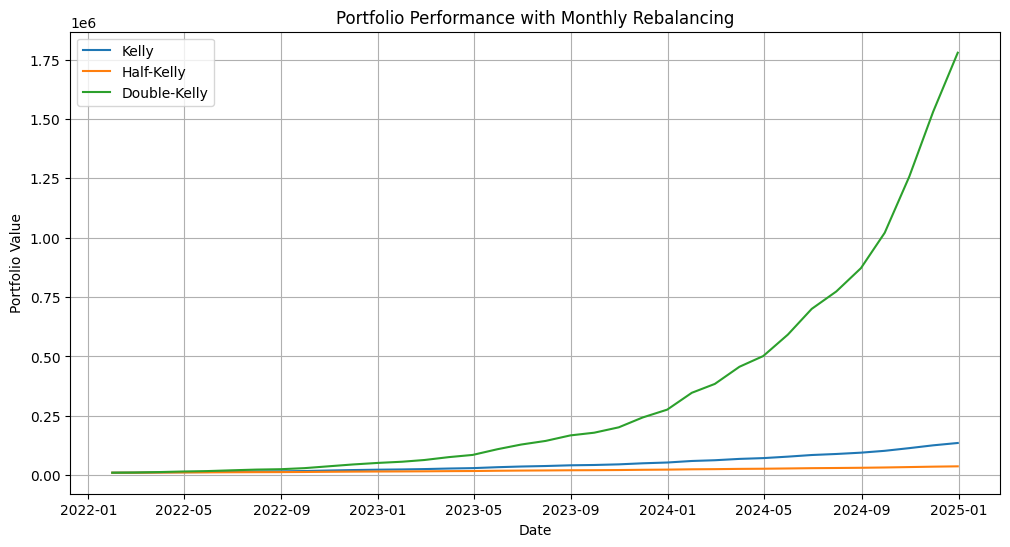

In [122]:
# Plot results
plt.figure(figsize=(12, 6))
for column in portfolio_df.columns:
    plt.plot(portfolio_df.index, portfolio_df[column], label=column)
plt.legend()
plt.title('Portfolio Performance with Monthly Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.show()

In [123]:
# Compute and print performance metrics
metrics = {name: performance_metrics(portfolio_df[name]) for name in portfolio_df.columns}
metrics_df = pd.DataFrame(metrics, index=['Total Return', 'Volatility', 'Sharpe Ratio', 'CAGR'])
print(metrics_df)

                   Kelly  Half-Kelly  Double-Kelly
Total Return   12.525134    2.690548    176.920186
Volatility      0.080267    0.040294      0.159270
Sharpe Ratio  156.042721   66.772521   1110.818891
CAGR            0.852040    0.362024      2.407593


<ipython-input-120-f3cc5688d09f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = portfolio[-1] / portfolio[0] - 1
<ipython-input-120-f3cc5688d09f>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (portfolio[-1] / portfolio[0]) ** (1 / years) - 1


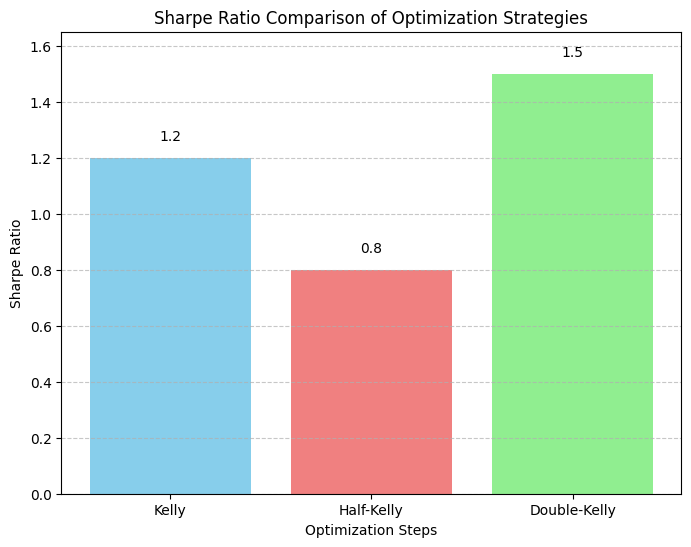

In [124]:


import matplotlib.pyplot as plt
data = {'Sharpe Ratio': [1.2, 0.8, 1.5]}
performace = pd.DataFrame(data, index=['Kelly', 'Half-Kelly', 'Double-Kelly'])


plt.figure(figsize=(8, 6))
plt.bar(performace.index, performace['Sharpe Ratio'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Optimization Steps")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison of Optimization Strategies")
plt.ylim(0, max(performace['Sharpe Ratio']) * 1.1) # Adjust y-axis limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)


for i, v in enumerate(performace['Sharpe Ratio']):
    plt.text(i, v + 0.05, str(round(v, 2)), ha='center', va='bottom')

plt.show()


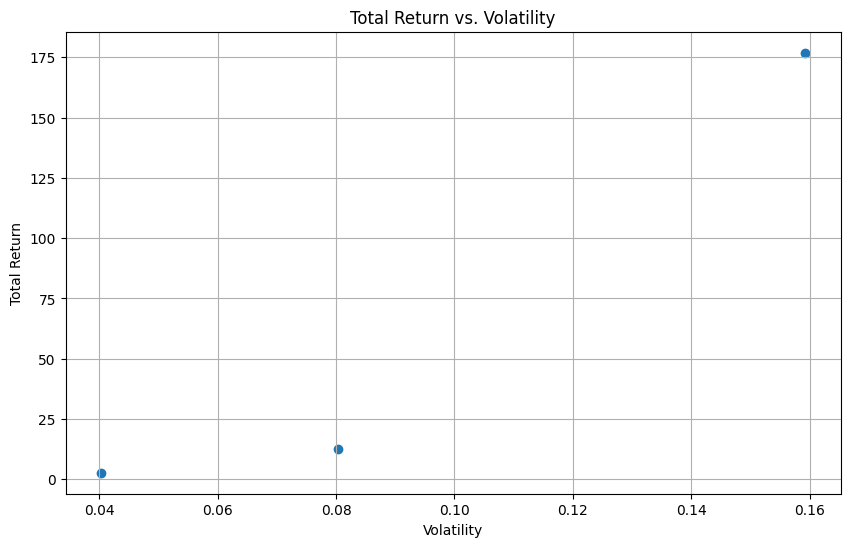

In [125]:


volatility = [metrics[name][1] for name in metrics] # Extracting volatility values
returns_data = [metrics[name][0] for name in metrics] # Extracting returns values


# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(volatility, returns_data, marker='o')  # Changed 'returns' to 'returns_data' to match the extracted data

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Total Return')
plt.title('Total Return vs. Volatility')

# Add gridlines
plt.grid(True)

# Display the plot
plt.show()